In [5]:
import imports
import load, fea, split, weights, model, compyl, train, ival, run

In [3]:
posf = 'input/main/dna_2537.fa'
negf = 'input/main/dna_12735.fa'
# model = run.run_pipeline(posf, negf)

In [4]:
sequences, labels = load.load_data(posf, negf)

In [7]:
merscore1, merscore2, merscore3, merscore4, merscore5, merscore6,kmer1, kmer2, kmer3 = fea.generate_features(sequences)

merscore1
merscore2
merscore3
merscore4
merscore5
merscore6


In [8]:
import numpy as np
feat = np.concatenate(
            (
                merscore1, merscore2, merscore3,
                merscore4, merscore5, merscore6,
                kmer1, kmer2, kmer3
            ),
            axis=1
        )
print(feat)

[[-0.02048864 -0.04667379 -0.06421899 ...  0.00665188  0.0443459
   0.01552106]
 [ 0.04149903  0.07394829  0.1089377  ...  0.00662252  0.
   0.        ]
 [ 0.01940514  0.04021537  0.06867714 ...  0.00399467  0.01331558
   0.00532623]
 ...
 [-0.00752795 -0.01860354 -0.02188427 ...  0.03133903  0.01994302
   0.02279202]
 [ 0.02214878  0.03624835  0.05684159 ...  0.00569801  0.02279202
   0.01994302]
 [-0.01585981 -0.0522365  -0.07348745 ...  0.02660754  0.01108647
   0.01773836]]


In [9]:
print(feat.shape)
print(labels.shape)

(15272, 90)
(15272,)


In [10]:
X = np.expand_dims(feat, axis=2).astype(np.float32)
y = labels.astype(np.float32)

print(X.shape)  # (36543, 90, 1)
print(y.shape)  # (36543,)


(15272, 90, 1)
(15272,)


In [11]:
import numpy as np

# (Optional but recommended)
X = X.astype(np.float32)
y = y.astype(np.float32)

np.save("X.npy", X)
np.save("y.npy", y)


In [3]:
import numpy as np

X = np.load("X.npy")
y = np.load("y.npy")

print(X.shape)  # (36543, 90, 1)
print(y.shape)  # (36543,)


(15272, 90, 1)
(15272,)


In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = split.stratified_split(X, y)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (9773, 90, 1) (9773,)
Val:   (2444, 90, 1) (2444,)
Test:  (3055, 90, 1) (3055,)


In [14]:
print("Train class distribution:", np.bincount(y_train.astype(int)))
print("Val class distribution:", np.bincount(y_val.astype(int)))
print("Test class distribution:", np.bincount(y_test.astype(int)))


Train class distribution: [8149 1624]
Val class distribution: [2038  406]
Test class distribution: [2548  507]


In [15]:
print(y_train.shape)

(9773,)


In [16]:
class_weights = weights.compute_class_weights(y_train)
print(class_weights)

{np.float32(0.0): np.float64(0.599644128113879), np.float32(1.0): np.float64(3.0089285714285716)}


In [22]:
class_weights = {
    int(k): float(v)
    for k, v in class_weights.items()
}

print(class_weights)
# Mistakes on positive samples are penalized ~3x more

{0: 0.599644128113879, 1: 3.0089285714285716}


In [19]:
from model import build_model
from compyl import compile_model

model1 = build_model()
model1 = compile_model(model1)

model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 90, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 90, 32)    │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 90, 32)    │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 90, 32)    │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 90, 96)    │          0 │ conv1d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 45, 96)    │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     41,216 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,017 (179.75 KB)

 Trainable params: 46,017 (179.75 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = train.train_model(model1, X_train, y_train, X_val, y_val)

Epoch 1/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6878 - pr_auc: 0.1615 - precision_1: 0.1605 - recall_1: 0.3939 - roc_auc: 0.4879
Epoch 1: val_pr_auc improved from None to 0.36057, saving model to best_dna.keras

Epoch 1: finished saving model to best_dna.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 0.6896 - pr_auc: 0.1916 - precision_1: 0.1815 - recall_1: 0.4692 - roc_auc: 0.5361 - val_loss: 0.4150 - val_pr_auc: 0.3606 - val_precision_1: 0.3569 - val_recall_1: 0.2488 - val_roc_auc: 0.7593 - learning_rate: 0.0010
Epoch 2/200
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5960 - pr_auc: 0.2977 - precision_1: 0.2908 - recall_1: 0.7321 - roc_auc: 0.7379
Epoch 2: val_pr_auc improved from 0.36057 to 0.43109, saving model to best_dna.keras

Epoch 2: finished saving model to best_dna.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.5938 - pr_auc: 0.3314 - precision_1: 0.2970 - recall_1: 0.7605 - roc_auc: 0.7493 - val_loss: 0.6637 - val_pr_auc: 0.4311 

In [23]:
results = model1.evaluate(X_test, y_test, verbose=0)

for name, value in zip(model1.metrics_names, results):
    print(f"{name}: {value:.4f}")


loss: 0.5003
compile_metrics: 0.6241


In [24]:
results = model1.evaluate(X_test, y_test, verbose=0, return_dict=True)
print(results)


{'loss': 0.5002802014350891, 'pr_auc': 0.6240953803062439, 'precision_1': 0.3777777850627899, 'recall_1': 0.8382642865180969, 'roc_auc': 0.8696634769439697}


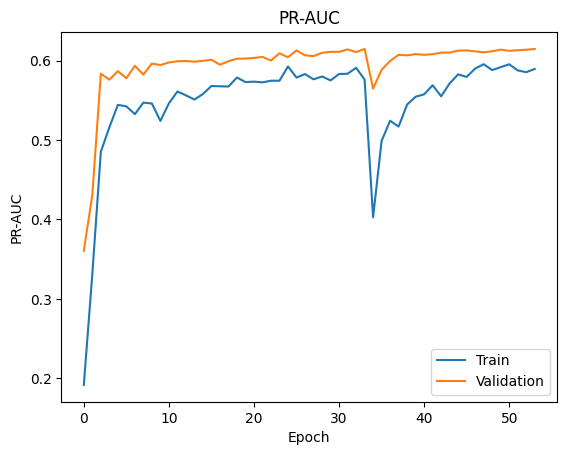

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['pr_auc'])
plt.plot(history.history['val_pr_auc'])
plt.title('PR-AUC')
plt.xlabel('Epoch')
plt.ylabel('PR-AUC')
plt.legend(['Train', 'Validation'])
plt.show()


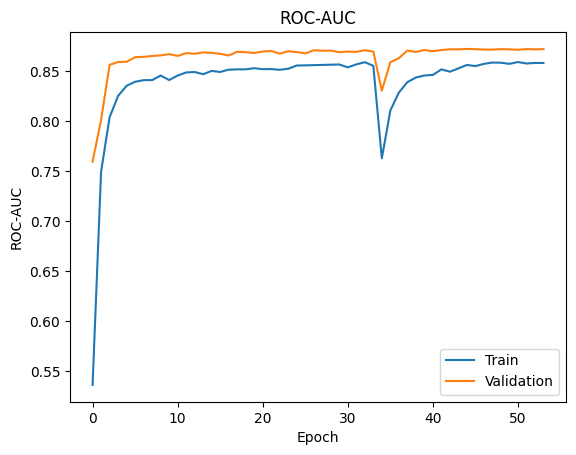

In [26]:
plt.plot(history.history['roc_auc'])
plt.plot(history.history['val_roc_auc'])
plt.title('ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend(['Train', 'Validation'])
plt.show()


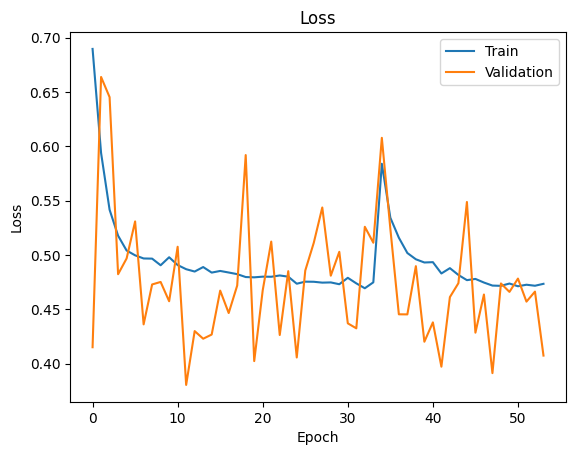

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [7]:
from tensorflow.keras.models import load_model
import numpy as np

model_path = "best_dna.keras"  
model1 = load_model(model_path)
predictions = model1.predict(X_test)  
predictions = predictions.flatten()    

predicted_labels = (predictions > 0.5).astype(int)
y_true = y_test.flatten().astype(int)

accuracy = (predicted_labels == y_true).mean()
print("Test Accuracy:", accuracy)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Test Accuracy: 0.744026186579378
